# For preprocessing information retrieval data (task specific)
## Samples of format : query, document text

In [35]:
import os
import json
import re
import string
import random
import time
import datetime

import numpy as np
import pandas as pd

from argparse import Namespace
from tqdm import tqdm_notebook
from datasets import Dataset

import transformers
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModelForMaskedLM

import torch.nn.functional as F
import torch

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

import matplotlib.pyplot as plt

Exception ignored in: <function tqdm.__del__ at 0x7f03db8a51b0>
Traceback (most recent call last):
  File "/home/jz75/Documents/2023-2024/SH-Project/CS4099-LegalNLP/pytorchenv/lib/python3.10/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/home/jz75/Documents/2023-2024/SH-Project/CS4099-LegalNLP/pytorchenv/lib/python3.10/site-packages/tqdm/notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


## Configurations

In [59]:
args = Namespace(
    raw_data_filename = 'r_legaladvice_train.json',
    raw_data_path = "raw_data/",
    processed_data_path = "processed_data/document_retrieval.csv",
    max_segment_length = 512,
    stride = 128,
    segment_method = 'sym-trunc', # sym-trunc, lex-trunc, start-trunc, end-trunc
    max_samples = 1000,
    mode = 'a', # a : append, w : write,
    train_split = 0.7,
)

Load & Process Raw Data

In [60]:
with open(args.raw_data_path + args.raw_data_filename, 'r') as json_file:
    json_data = json.load(json_file)

In [61]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

Text(0, 0.5, '# of Samples ')

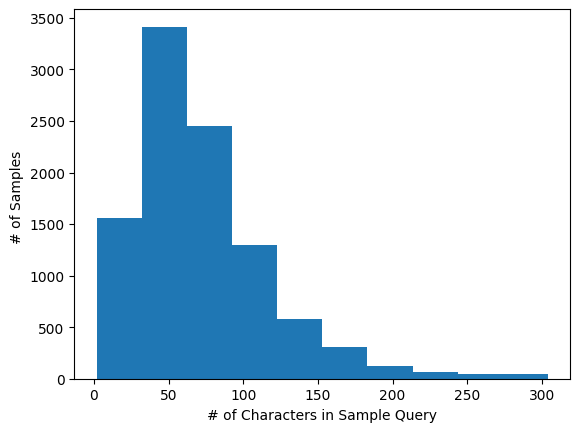

In [62]:
query_lengths = []
for sample in json_data:
    query_lengths.append(len(sample['query']))

main_lengths = []
for sample in json_data:
    main_lengths.append(len(sample['text']))

plt.hist(query_lengths)
plt.xlabel('# of Characters in Sample Query')
plt.ylabel('# of Samples ')




Text(0, 0.5, '# of Samples ')

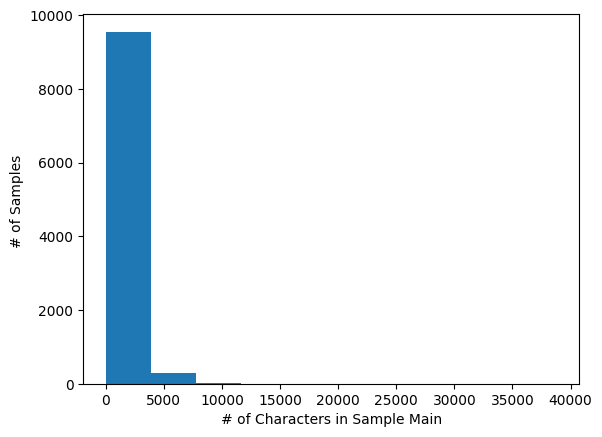

In [63]:
plt.hist(main_lengths)
plt.xlabel('# of Characters in Sample Main')
plt.ylabel('# of Samples ')

In [4]:
def split_text_generator(paragraph, max_length=1024):
    '''
      Takes a paragraph of text and splits into sections of length less than specific limit max_length
      Creates a generator over the subsections
    '''
    def find_split_index(s, start):
        end = min(start + max_length, len(s))
        split_index = s.rfind(' ', start, end)
        return split_index if split_index != -1 else end

    start = 0
    while start < len(paragraph):
        split_index = find_split_index(paragraph, start)
        yield paragraph[start:split_index].strip()
        start = split_index + 1 if split_index < len(paragraph) else len(paragraph)


def split_paragraph_list(paragraph, max_length=1024, stride=128):
    '''
      Takes a paragraph of text and splits into sections of length less than specific limit max_length with a specific stride
      Returns the subsections as a list
    '''
    def find_split_index(s, start):
        end = min(start + max_length, len(s))

        if end == len(s): return len(s)

        split_index = s.rfind(' ', start, end)
        return split_index if split_index != -1 else end

    sections = []
    start = 0
    while start < len(paragraph):
        split_index = find_split_index(paragraph, start)
        sections.append(paragraph[start:split_index].strip())
        # start = split_index + 1 if split_index < len(paragraph) else len(paragraph)

        if start + stride >= len(paragraph) or split_index >= len(paragraph): break

        next_start = paragraph.rfind(' ', start, start+stride)

        start = next_start + 1 if next_start != -1 else len(paragraph)

    return sections

Setup TF-IDF over corpus

In [64]:
stopwords = list(text.ENGLISH_STOP_WORDS)

vectorizer = TfidfVectorizer(stop_words=stopwords, token_pattern=r'\b[^\d\W]+\b')

tfidf = vectorizer.fit_transform([obj['text'] for obj in json_data[0 : 10]])

In [42]:
def text_similarity(main_text, text_list):

  # Encode the main text
  inputs_main = tokenizer(main_text, return_tensors='pt', truncation=True, max_length=512)
  with torch.no_grad():
      outputs_main = model(**inputs_main)
  embedding_main = outputs_main.last_hidden_state[:, 0, :]

  max_similarity = -1
  most_similar_text = None

  for text in text_list:
      # Encode each text in the list
      inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
      with torch.no_grad():
          outputs = model(**inputs)

      # Get the [CLS] embeddings
      embedding = outputs.last_hidden_state[:, 0, :]

      # Compute similarity
      similarity = F.cosine_similarity(embedding_main, embedding)
      if similarity > max_similarity:
          max_similarity = similarity
          most_similar_text = text

  return most_similar_text

def lexical_text_similarity(main_text, text_list):
  query_vector = vectorizer.transform([main_text])

  tfidf_list = vectorizer.transform(text_list)

  similarities = linear_kernel(query_vector, tfidf_list).flatten()

  ranked_documents = [(text_list[i], score) for i, score in enumerate(similarities) if score > 0]
  ranked_documents.sort(key=lambda x: x[1], reverse=True)

  if len(ranked_documents):
    return ranked_documents[0]
  else :
    return text_list[0]
  
       

In [25]:
def clean_text(text):
  text = re.sub(r'\s\s+', ' ', text)

  # # Pattern for document identifiers
  # doc_id_pattern = r'\b\d{1,3}\sU\.S\.C\.\s\d{1,5}\([a-zA-Z0-9]+\)'

  # # Pattern for list numbers
  # list_number_pattern = r'\(\d+\)'

  # # Replace document identifiers
  # text = re.sub(doc_id_pattern, '<DOC_ID>', text)

  # # Replace list numbers
  # text = re.sub(list_number_pattern, '<LIST_NUM>', text)

  return text.strip()

In [65]:
all_data = []
count = 0
for sample in json_data:
    if len(all_data) >= args.max_samples: break

    query = clean_text(sample['query'])
    document = clean_text(sample['text'])

    if len(query) > 1024:
       continue

    if len(document) > 1024:
      subsections = split_paragraph_list(document)

      # document = text_similarity(query, subsections)
      document = lexical_text_similarity(query, subsections)[0]

    all_data.append((query, document))


0


In [66]:
df = pd.DataFrame(all_data, columns=['query', 'document'])

df.head()

,query,document
0,My former employer fired everyone when they ha...,The title says most of it. I just heard back f...
1,Landlord is updating snow removal policies and...,her car she was advised by representatives of ...
2,Ceiling collapse,"Hello all, I moved into my apartment in August..."
3,Need Help with Rescheduling 2020 Wedding,"My wedding date is September 6th, 2020. Due to..."
4,TX Emergency Advice,So not 100% sure where this goes but I figured...


In [67]:
df.to_csv(args.processed_data_path, mode=args.mode)